In [2]:
import hoomd
from hoomd import hpmc, md
import math
import numpy as np
def extrapolate(s, dx, xmax, degree=5):
  # determine the number of values to fit
  n_fit = int(math.ceil(xmax/dx));
  s_fit = s[0:n_fit];
  # construct the x coordinates
  x_fit = np.arange(0,xmax,dx)
  x_fit += dx/2;
  # perform the fit and extrapolation
  p = np.polyfit(x_fit, s_fit, degree);
  return p, np.polyval(p, 0.0);

In [7]:
import matplotlib.pyplot as plt
def overlapper(pts, sigma=1):
    pts_np = np.array(pts)
    pts_mtx = np.sqrt(((pts_np[:,:,None] - pts_np[:,:,None].T)**2).sum(1))
    np.fill_diagonal(pts_mtx, 99999.0)
#     print(pts_mtx, pts_mtx.shape)
#     print(np.min(pts_mtx,axis=1) < sigma)
    return np.where(np.min(pts_mtx,axis=1) < sigma)
def plot_config_wrap(pts,L=1,title=None,color_overlapper=False,lm=None,ring=None):
    
    fig, ax = plt.subplots()
#     print(f'Length of pts is {len(pts)}')
    if lm is None:
        lm = 1 # length_multiplier - for larger plots when points are more
        if len(pts) > 256:
            lm = np.sqrt(len(pts)/256.0)
        if len(pts) > 256*9:
            lm = 3
#     print(f'lm is {lm}')
    fig.set_size_inches(6*lm,6*lm)
    
    if ring is None:
        if len(pts) > 2048:
            ring=False
        else:
            ring=True
    
    
    pts_addl = []
    for p in pts:
        if p[0] < -L/2+0.5:
            pts_addl.append([p[0]+L, p[1]])  
            if p[1] < -L/2+0.5:
                pts_addl.append([p[0]+L, p[1]+L])
            if p[1] > -L/2+0.5:
                pts_addl.append([p[0]+L, p[1]-L])
        if p[0] > L/2+0.5:
            pts_addl.append([p[0]-L, p[1]])
            if p[1] < -L/2+0.5:
                pts_addl.append([p[0]-L, p[1]+L])
            if p[1] > L/2+0.5:
                pts_addl.append([p[0]-L, p[1]-L])
        if p[1] < -L/2+0.5:
            pts_addl.append([p[0], p[1]+L])
        if p[1] > L/2+0.5:
            pts_addl.append([p[0], p[1]-L])

    if len(pts_addl) > 0:
        pts_addl = np.array(pts_addl)
        pts_total = np.vstack([pts,pts_addl])
    else:
        pts_total = pts
        
    if color_overlapper:
        overlapping_particles = overlapper(pts_total)[0]
    if ring:
        circles = [plt.Circle(p,.5,alpha=0.5,ec='red') for p in pts]
        circles2 = [plt.Circle(p,.5,alpha=0.5,ec='red') for p in pts_addl]
    else:
        circles = [plt.Circle(p,.5,alpha=0.5) for p in pts]
        circles2 = [plt.Circle(p,.5,alpha=0.5) for p in pts_addl]


    for c in circles:
        ax.add_patch(c)
    for c in circles2:
        ax.add_patch(c)
    if color_overlapper:
        circles_overlap  = [plt.Circle(pts_total[ii],.5,alpha=0.5,ec='none',fc='tab:red') for ii in overlapping_particles]
        for c in circles_overlap:
            ax.add_patch(c)
    ax.set_xlim(-L/2,L/2)
    ax.set_ylim(-L/2,L/2)
    if title is not None:
        ax.set_title(title)

In [2]:

phi = 0.2 # packing fraction
sigma = 1
N = 64
L = (N*(np.pi*0.25*sigma**2)/phi)**0.5
a = L/np.sqrt(N)

hoomd.context.initialize('')
box = hoomd.data.boxdim(L=L,dimensions=2)
snap = hoomd.data.make_snapshot(N=N,particle_types=['A'],box=box)

snap.particles.position[:] = [(i,j,0) for i in np.arange(-L/2,L/2,a) for j in np.arange(-L/2,L/2,a)]

system = hoomd.init.read_snapshot(snap)
mc = hpmc.integrate.sphere(seed=123)
sigma=1

mc.shape_param.set('A',diameter=sigma)
gsd = hoomd.dump.gsd('trajectory.gsd',period=1,group=hoomd.group.all(),overwrite=True)
mc.set_params(d=0.05)

HOOMD-blue 2.9.6 CUDA (11.0) DOUBLE HPMC_MIXED TBB SSE SSE2 SSE3 
Compiled: 03/17/2021
Copyright (c) 2009-2019 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, J Glaser, and S C Glotzer. "HOOMD-blue: A Python package for
  high-performance molecular dynamics and hard particle Monte Carlo
  simulations", Computational Materials Science 173 (2020) 109363
-----
-----
You are using HPMC. Please cite the following:
* J A Anderson, M E Irrgang, and S C Glotzer. "Scalable Metropolis Monte Carlo
  for simulation of hard shapes", Computer Physics Communications 204 (2016) 21
  --30
-----
HOOMD-blue is running on the following GPU(s):
 [0]  Tesla V100-PCIE-16GB  80 SM_7.0 @ 1.38 GHz, 16160 MiB DRAM, MNG
notice(2): Setting number of TBB threads to value of OMP_NUM_THREADS=12
notice(2): Group "all" created containing 64 particles


In [71]:
hpmc.analyze.sdf(mc=mc, filename='sdf.dat', xmax=0.02, dx=1e-4, navg=100, period=100,overwrite=True)
# analyze.sdf(mc=mc, filename='sdf.dat', xmax=0.002, dx=1e-5, navg=100, period=100)

In [72]:
hoomd.run(10000)

** starting run **
Time 00:00:02 | Step 10000 / 10000 | TPS 4015.21 | ETA 00:00:00
Average TPS: 4013.81
---------
notice(2): -- HPMC stats:
notice(2): Average translate acceptance: 0.942422
notice(2): Trial moves per second:        1.00924e+06
notice(2): Overlap checks per second:     3.34318e+06
notice(2): Overlap checks per trial move: 3.31258
notice(2): Number of overlap errors:      0
-- Cell list stats:
Dimension: 14, 14, 1
n_min    : 0 / n_max: 1 / n_avg: 0.326531
** run complete **


In [74]:
sdf = np.loadtxt('sdf.dat')[1:]

In [75]:
sdf

array([ 0.    ,  6.25  ,  0.    ,  6.25  ,  3.125 ,  3.125 ,  3.125 ,
        0.    , 12.5   ,  0.    ,  3.125 ,  3.125 ,  0.    ,  0.    ,
        3.125 ,  0.    ,  0.    ,  0.    ,  3.125 ,  3.125 ,  0.    ,
        0.    ,  0.    ,  6.25  ,  3.125 ,  3.125 ,  3.125 ,  3.125 ,
        0.    ,  3.125 ,  3.125 ,  0.    ,  3.125 ,  3.125 ,  0.    ,
        3.125 ,  9.375 ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        3.125 ,  6.25  ,  0.    ,  3.125 ,  0.    ,  3.125 ,  3.125 ,
        0.    ,  0.    ,  9.375 ,  3.125 ,  3.125 ,  0.    ,  0.    ,
        0.    ,  0.    ,  6.25  ,  3.125 ,  0.    ,  9.375 ,  0.    ,
        3.125 ,  0.    ,  3.125 ,  0.    ,  0.    ,  6.25  ,  0.    ,
        6.25  ,  0.    ,  0.    ,  3.125 ,  0.    ,  3.125 ,  3.125 ,
        6.25  ,  3.125 ,  3.125 ,  0.    ,  3.125 ,  9.375 ,  3.125 ,
        0.    ,  3.125 ,  6.25  ,  0.    ,  6.25  ,  0.    ,  0.    ,
        3.125 ,  0.    ,  0.    ,  0.    ,  6.25  ,  3.125 ,  6.25  ,
        0.    ,  3.1

In [76]:
p, a = extrapolate(sdf, 1e-4, 0.02)

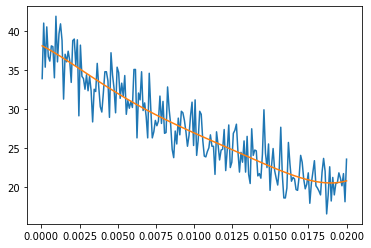

In [9]:
import matplotlib.pyplot as plt
x = np.linspace(1e-4/2, 0.02, len(sdf))
plt.plot(x, sdf)
plt.plot(x, np.polyval(p, x))

In [78]:
P = phi * (1 + a / 2 / 2)

In [79]:
P

0.35785388913083616

In [86]:
np.arange(3,5,1)

array([3, 4])

In [3]:
# Loop through various values
x = [0.706]
P = []
for phi in x:
    print(phi)
# phi = 0.2 # packing fraction
    sigma = 1
    N = 1024
    L = (N*(np.pi*0.25*sigma**2)/phi)**0.5
    a = L/np.sqrt(N)

    hoomd.context.initialize('')
    box = hoomd.data.boxdim(L=L,dimensions=2)
    snap = hoomd.data.make_snapshot(N=N,particle_types=['A'],box=box)

    snap.particles.position[:] = [(i,j,0) for i in np.arange(-L/2,L/2,a) for j in np.arange(-L/2,L/2,a)]

    system = hoomd.init.read_snapshot(snap)
    mc = hpmc.integrate.sphere(seed=123)
    sigma=1

    mc.shape_param.set('A',diameter=sigma)
    gsd = hoomd.dump.gsd('trajectory.gsd',period=1,group=hoomd.group.all(),overwrite=True)
    mc.set_params(d=0.05)
    hpmc.analyze.sdf(mc=mc, filename='sdf.dat', xmax=0.02, dx=1e-4, navg=100, period=100,overwrite=True)
    # analyze.sdf(mc=mc, filename='sdf.dat', xmax=0.002, dx=1e-5, navg=100, period=100)
    hoomd.run(30000)
    try:
        sdf = np.loadtxt('sdf.dat')[-1][1:]
    except:
        sdf = np.loadtxt('sdf.dat')[1:]
    p, a = extrapolate(sdf, 1e-4, 0.02)
    P.append(phi * (1 + a / 2 / 2))

0.706
HOOMD-blue 2.9.6 CUDA (11.0) DOUBLE HPMC_MIXED TBB SSE SSE2 SSE3 
Compiled: 03/17/2021
Copyright (c) 2009-2019 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, J Glaser, and S C Glotzer. "HOOMD-blue: A Python package for
  high-performance molecular dynamics and hard particle Monte Carlo
  simulations", Computational Materials Science 173 (2020) 109363
-----
-----
You are using HPMC. Please cite the following:
* J A Anderson, M E Irrgang, and S C Glotzer. "Scalable Metropolis Monte Carlo
  for simulation of hard shapes", Computer Physics Communications 204 (2016) 21
  --30
-----
HOOMD-blue is running on the following GPU(s):
 [0]  Tesla V100-PCIE-16GB  80 SM_7.0 @ 1.38 GHz, 16160 MiB DRAM, MNG
notice(2): Setting number of TBB threads to value of OMP_NUM_THREADS=12
notice(2): Group "all" created containing 1024 particles
** starting run **
Time 00:00:10 | Step 19002 / 30000 | TPS 1900.14 | ETA 00:00:05
Time 00:00

In [4]:
P

[7.438159653975857]

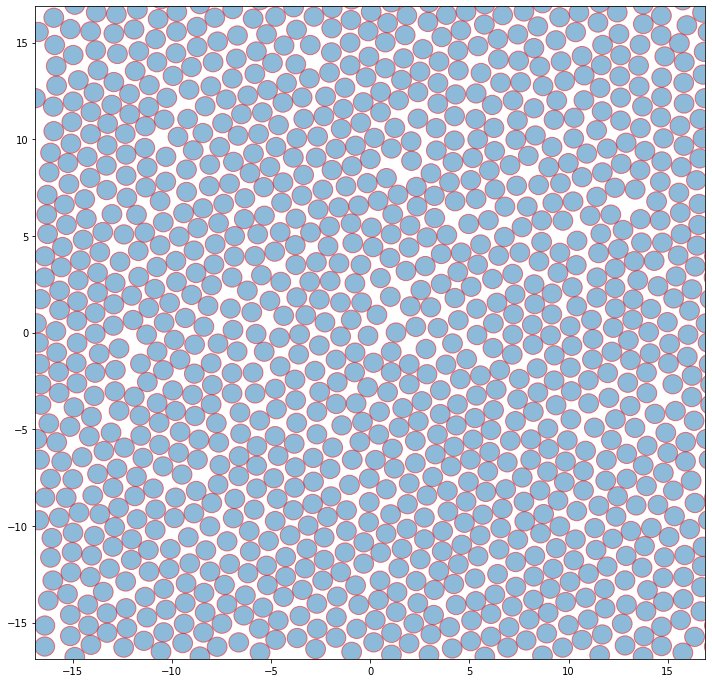

In [8]:
snap = system.take_snapshot()
pts = snap.particles.position[:,:2]
plot_config_wrap(pts,L=system.box.Lx, color_overlapper=True)

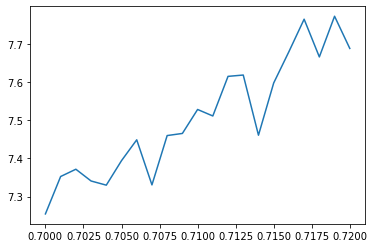

In [4]:
import matplotlib.pyplot as plt
plt.plot(x, np.array(P))